In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gc
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv

In [2]:
# load the new file
df = read_csv('./data/bitcoin_data.csv', date_parser = True)
df.drop(df.columns[0], axis=1,inplace = True)
len(df)

19433

In [3]:
df = df[df['NewDateTime']>= '2021-01-01'].copy()
len(df)

4554

In [4]:
df.drop(df.head(len(df)%192).index,inplace=True)
len(df)

4416

In [5]:
int(len(df)/8*7)

3864

In [6]:
data_training = df.iloc[0:int(len(df)/8*7),:]
data_test = df.iloc[int(len(df)/8*7):int(len(df)),:]

len(data_training)

3864

In [7]:
training_data = data_training.drop(['NewDateTime'], axis = 1)


training_data

,close,open,high,low,Volume BTC,returns,log_returns,SOPR,fundingRate,googleTrend
15017,35890.00,36031.27,36038.27,35830.07,1562.950120,0.996079,-0.003928,0.997157,0.01,58
15018,35747.15,35889.99,35889.99,35705.00,1409.824964,0.996020,-0.003988,0.997157,0.01,59
15019,35971.67,35747.14,35995.28,35581.72,2215.940472,1.006281,0.006261,0.997157,0.01,62
15020,35938.61,35971.67,35984.71,35860.00,1420.884639,0.999081,-0.000919,0.997157,0.01,63
15021,35554.86,35938.61,35950.00,35222.00,3314.746947,0.989322,-0.010735,0.997157,0.01,61
...,...,...,...,...,...,...,...,...,...,...
18876,64170.00,64028.34,64209.07,63872.46,895.510180,1.002212,0.002210,1.001468,0.01,69
18877,64221.78,64169.99,64500.00,64040.47,993.109780,1.000807,0.000807,1.001468,0.01,69
18878,64308.59,64221.78,64500.00,64050.00,780.833260,1.001352,0.001351,1.001468,0.01,69
18879,64520.00,64308.58,64900.00,64284.79,1044.801300,1.003287,0.003282,1.001468,0.01,69


In [8]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data

array([[0.16883007, 0.17240962, 0.16113335, ..., 0.45877554, 0.47406866,
        0.36363636],
       [0.16520395, 0.16882348, 0.15735966, ..., 0.45877554, 0.47406866,
        0.37878788],
       [0.17090319, 0.16519749, 0.16003926, ..., 0.45877554, 0.47406866,
        0.42424242],
       ...,
       [0.89021112, 0.88797526, 0.88547628, ..., 0.50944617, 0.47406866,
        0.53030303],
       [0.89557758, 0.89017853, 0.89565617, ..., 0.50944617, 0.47406866,
        0.53030303],
       [0.92093886, 0.8955453 , 0.91221146, ..., 0.50944617, 0.47406866,
        0.53030303]])

In [9]:
scaler.scale_

array([2.53841253e-05, 2.53832103e-05, 2.54497156e-05, 2.52231047e-05,
       2.96465649e-05, 8.91552170e+00, 8.83926598e+00, 1.17531472e+01,
       7.30460190e+00, 1.51515152e-02])

In [10]:
X_train = []
Y_train = []

In [11]:
training_data.shape

(3864, 10)

In [12]:
for i in range(336, training_data.shape[0],24):
    
    X_train.append(training_data[i-336:i-168])
    Y_train.append(training_data[i-168:i,0])

In [13]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [14]:
X_train.shape

(3528, 168, 10)

In [15]:
Y_train.shape

(3528, 168)

In [16]:
Y_train[168,:,0]

IndexError: too many indices for array

In [17]:
Y_train=Y_train.reshape(Y_train.shape[0],168,1)

In [18]:
# Y_train[1,:,0]

In [19]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,RepeatVector,TimeDistributed

In [31]:

model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 10)))
model.add(Dropout(0.3))
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu' ,return_sequences = True))
model.add(Dropout(0.5))

model.add(TimeDistributed(Dense(1)))

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 168, 50)           12200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 168, 50)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 168, 60)           26640     
_________________________________________________________________
dropout_13 (Dropout)         (None, 168, 60)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 168, 80)           45120     
_________________________________________________________________
dropout_14 (Dropout)         (None, 168, 80)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 168, 120)         

In [33]:
model.compile(loss='mse', optimizer='adam')

In [34]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=150, verbose=1, validation_split=0.1)

Train on 3175 samples, validate on 353 samples
Epoch 1/10
3175/3175 [==============================] - 34s 11ms/sample - loss: 0.0758 - val_loss: 0.0976
Epoch 2/10
3175/3175 [==============================] - 31s 10ms/sample - loss: 0.0315 - val_loss: 0.0402
Epoch 3/10
3175/3175 [==============================] - 30s 10ms/sample - loss: 0.0239 - val_loss: 0.0380
Epoch 4/10
3175/3175 [==============================] - 30s 10ms/sample - loss: 0.0196 - val_loss: 0.0263
Epoch 5/10
3175/3175 [==============================] - 30s 9ms/sample - loss: 0.0172 - val_loss: 0.0295
Epoch 6/10
3175/3175 [==============================] - 30s 9ms/sample - loss: 0.0151 - val_loss: 0.0407
Epoch 7/10
3175/3175 [==============================] - 30s 9ms/sample - loss: 0.0139 - val_loss: 0.0304
Epoch 8/10
3175/3175 [==============================] - 30s 10ms/sample - loss: 0.0132 - val_loss: 0.0438
Epoch 9/10
3175/3175 [==============================] - 30s 9ms/sample - loss: 0.0121 - val_loss: 0.0242
Epo

In [20]:
import tensorflow as tf
model = tf.keras.models.load_model('168_168.h5')

In [36]:
# model.save("168_168.h5")

In [37]:
# result = model.predict(X_train, batch_size=128, verbose=0)
# for value in result[0,:,0]:
# 	print('%.1f' % value)

In [21]:
loss = history.history['loss']
epoch = range(len(loss))
# plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

NameError: name 'history' is not defined

In [22]:
history.history

NameError: name 'history' is not defined

In [23]:
# from tensorflow import keras
# regressor = Sequential()
# regressor = keras.models.load_model("LSTM_model_1210.h5")

In [50]:
past_weeks = data_training.tail(168)
df= past_weeks.append(data_test, ignore_index = True)
# test.drop(test.tail(len(test)%168).index,inplace=True)
# test = test.drop(['NewDateTime'], axis=1)
df

,close,open,high,low,Volume BTC,NewDateTime,returns,log_returns,SOPR,fundingRate,googleTrend
0,64999.68,63273.58,65040.96,63273.58,8026.87592,2021-11-08 00:00:00,1.027280,0.026914,1.006743,0.0374,89
1,65077.27,64999.68,65639.08,64937.32,4420.86652,2021-11-08 01:00:00,1.001194,0.001193,1.006743,0.0374,89
2,65078.12,65077.27,65329.11,65042.75,1607.63976,2021-11-08 02:00:00,1.000013,0.000013,1.006743,0.0374,89
3,65199.99,65078.11,65235.28,64966.27,1563.65354,2021-11-08 03:00:00,1.001873,0.001871,1.006743,0.0374,89
4,65168.20,65200.00,65357.00,65050.77,1314.57002,2021-11-08 04:00:00,0.999512,-0.000488,1.006743,0.0374,89
...,...,...,...,...,...,...,...,...,...,...,...
715,50884.48,50921.61,51204.77,50666.00,1312.93360,2021-12-07 19:00:00,0.999271,-0.000729,1.004981,0.0039,23
716,50441.59,50884.49,51006.20,50150.00,2194.52091,2021-12-07 20:00:00,0.991296,-0.008742,1.004981,0.0039,23
717,50489.92,50441.59,50856.46,50358.99,1468.15088,2021-12-07 21:00:00,1.000958,0.000958,1.004981,0.0039,23
718,50245.25,50489.93,50626.43,50039.74,1362.13177,2021-12-07 22:00:00,0.995154,-0.004858,1.004981,0.0039,23


In [48]:
past_weeks

,close,open,high,low,Volume BTC,NewDateTime,returns,log_returns,SOPR,fundingRate,googleTrend
18713,64999.68,63273.58,65040.96,63273.58,8026.87592,2021-11-08 00:00:00,1.027280,0.026914,1.006743,0.0374,89
18714,65077.27,64999.68,65639.08,64937.32,4420.86652,2021-11-08 01:00:00,1.001194,0.001193,1.006743,0.0374,89
18715,65078.12,65077.27,65329.11,65042.75,1607.63976,2021-11-08 02:00:00,1.000013,0.000013,1.006743,0.0374,89
18716,65199.99,65078.11,65235.28,64966.27,1563.65354,2021-11-08 03:00:00,1.001873,0.001871,1.006743,0.0374,89
18717,65168.20,65200.00,65357.00,65050.77,1314.57002,2021-11-08 04:00:00,0.999512,-0.000488,1.006743,0.0374,89
...,...,...,...,...,...,...,...,...,...,...,...
18876,64170.00,64028.34,64209.07,63872.46,895.51018,2021-11-14 19:00:00,1.002212,0.002210,1.001468,0.0100,69
18877,64221.78,64169.99,64500.00,64040.47,993.10978,2021-11-14 20:00:00,1.000807,0.000807,1.001468,0.0100,69
18878,64308.59,64221.78,64500.00,64050.00,780.83326,2021-11-14 21:00:00,1.001352,0.001351,1.001468,0.0100,69
18879,64520.00,64308.58,64900.00,64284.79,1044.80130,2021-11-14 22:00:00,1.003287,0.003282,1.001468,0.0100,69


In [ ]:
df = df.drop(['NewDateTime'], axis = 1)
len(df)

In [45]:
inputs = scaler.transform(df)
inputs

array([[ 0.90775383,  0.8639069 ,  0.89924356, ...,  0.57144415,
         0.67421476,  0.83333333],
       [ 0.90972339,  0.90772086,  0.91446554, ...,  0.57144415,
         0.67421476,  0.83333333],
       [ 0.90974497,  0.90969035,  0.90657689, ...,  0.57144415,
         0.67421476,  0.83333333],
       ...,
       [ 0.53943627,  0.5381898 ,  0.53825207, ...,  0.55073454,
         0.42951059, -0.16666667],
       [ 0.53322554,  0.53941683,  0.53239787, ...,  0.55073454,
         0.42951059, -0.16666667],
       [ 0.54195006,  0.53320606,  0.5345499 , ...,  0.55073454,
         0.42951059, -0.18181818]])

In [46]:
X_test = []
Y_test = []
for i in range(336, inputs.shape[0],24):
    X_test.append(inputs[i-336:i-168])
    Y_test.append(inputs[i-168:i,0])

In [27]:
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test.shape, Y_test.shape

((16, 168, 10), (16, 168))

In [28]:
Y_test=Y_test.reshape(Y_test.shape[0],168,1)

In [29]:
Y_pred = model.predict(X_test)
Y_pred, Y_test

(array([[[0.11512636],
         [0.20059523],
         [0.29271132],
         ...,
         [0.83803475],
         [0.8395389 ],
         [0.841097  ]],
 
        [[0.11521659],
         [0.20089   ],
         [0.2931586 ],
         ...,
         [0.82231814],
         [0.81886715],
         [0.81534845]],
 
        [[0.11536277],
         [0.20134586],
         [0.29396623],
         ...,
         [0.5486582 ],
         [0.54431593],
         [0.54070383]],
 
        ...,
 
        [[0.11506741],
         [0.20090093],
         [0.2943114 ],
         ...,
         [0.5747092 ],
         [0.5769145 ],
         [0.5787866 ]],
 
        [[0.11400807],
         [0.19727837],
         [0.28608894],
         ...,
         [0.60082126],
         [0.6016535 ],
         [0.6029335 ]],
 
        [[0.11383727],
         [0.19658639],
         [0.28434786],
         ...,
         [0.63469726],
         [0.6358634 ],
         [0.6369914 ]]], dtype=float32),
 array([[[0.92997738],
         [0.93051

In [30]:
Y_pred.shape

(16, 168, 1)

In [31]:
scaler.scale_

array([2.53841253e-05, 2.53832103e-05, 2.54497156e-05, 2.52231047e-05,
       2.96465649e-05, 8.91552170e+00, 8.83926598e+00, 1.17531472e+01,
       7.30460190e+00, 1.51515152e-02])

In [32]:
scale = 1/2.53841253e-05
scale

39394.699962342216

In [33]:
# scale.inverse_transform(Y_pred)

In [34]:
Y_test = Y_test*scale
Y_pred = Y_pred*scale

In [35]:
Y_pred.shape

(16, 168, 1)

In [36]:
Y_test[0,0,0]

36636.17996497911

In [37]:
len(Y_pred[1,:,0])

168

In [38]:
Y_pred[1,:,0]

array([ 4538.923 ,  7914.0015, 11548.895 , 15194.009 , 18574.883 ,
       21410.49  , 23486.078 , 24839.307 , 25686.754 , 26187.027 ,
       26449.703 , 26549.191 , 26537.924 , 26456.932 , 26334.625 ,
       26191.535 , 26040.617 , 25889.865 , 25744.086 , 25606.713 ,
       25481.402 , 25371.586 , 25277.062 , 25195.812 , 25122.865 ,
       25058.443 , 25003.94  , 24959.701 , 24926.945 , 24905.451 ,
       24895.184 , 24895.322 , 24915.125 , 24959.488 , 25029.322 ,
       25121.146 , 25229.244 , 25351.584 , 25488.068 , 25636.855 ,
       25785.088 , 25924.266 , 26045.83  , 26141.914 , 26205.031 ,
       26227.115 , 26213.055 , 26167.48  , 26105.846 , 26042.566 ,
       25987.736 , 25949.037 , 25930.129 , 25932.738 , 25956.703 ,
       26001.688 , 26075.658 , 26182.05  , 26318.94  , 26480.955 ,
       26659.936 , 26847.37  , 27037.48  , 27224.113 , 27408.24  ,
       27589.627 , 27766.592 , 27940.055 , 28108.398 , 28270.742 ,
       28426.572 , 28573.367 , 28720.008 , 28881.936 , 29074.8

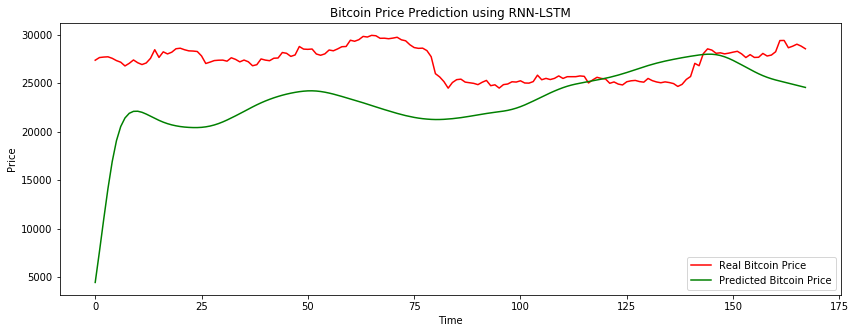

In [43]:
plt.figure(figsize=(14,5))
plt.plot(Y_test[8,0:,0], color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred[8,0:,0], color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()